<h1><center>Deep Learning : Assignment 04</h1>
<h1><center>MSCS18030 - Muhammad Rauf Tabassam</h1>

#Objectives
In this assignment you are required to write code for detecting infections such as COVID-19 among X-Ray images: 

1. Use CNN, pre-trained on ImageNet, to extract basic features from X-Ray images.
2. Train the classification layers in order to detect instances of Infected (COVID-19 + Pneumonia) and Normal X-Ray images.
3. Fine-tune the entire network to try to improve performance.


# Chest X-Ray Images Dataset
## Background
New studies [1] have revealed that the damage done to lungs by infections belonging to the family of coronaviruses (COVID-19, SARS, ARDS etc.) can be observed in X-Ray and CT scan images. With a worldwide shortage of test kits, it is possible that careful analysis of X-Ray and CT scan images may be used in diagnosis of COVID-19 and for the regular assessment while they are recovering. In this assignment, we will use an open source dataset of X-Ray images and train a Convolutional Neural Network to try and detect instances of infections containing COVID-19 and Pneumonia.

## Dataset Details: 
This dataset contains X-Ray images from 2 classes:
#### Class: Infected
1. No. of images in training set: 4919  
2. No. of images in validation set: 615
3. No. of images in test set: 615

#### Class: Normal
1. No. of images in training set: 7081
2. No. of images in validation set: 885
3. No. of images in test set: 885

Chest X-Ray images are taken in different views (AP or PA) depending on which side of the body is facing the X-Ray scanner. Images from different views have slightly different features. For this task, we will be using images without considering their views. A few sample images:

![image](https://drive.google.com/file/d/1eeRfcLR8W1CEZEG77UY1eKc4raFcNvjp/view?usp=sharing)


[1]  Zu, Zi Yue, et al. "Coronavirus disease 2019 (COVID-19): a perspective from China." Radiology (2020): 200490.


In [1]:
from google.colab import drive
drive.mount("./drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [0]:
data_dir = '/content/drive/My Drive/Assignment 5 Dataset'

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=validation_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

print("train_data: ", len(train_data))
print("validation_data: ", len(validation_data))
print("test_data: ", len(test_data))

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)


train_data:  10747
validation_data:  1500
test_data:  1500
Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


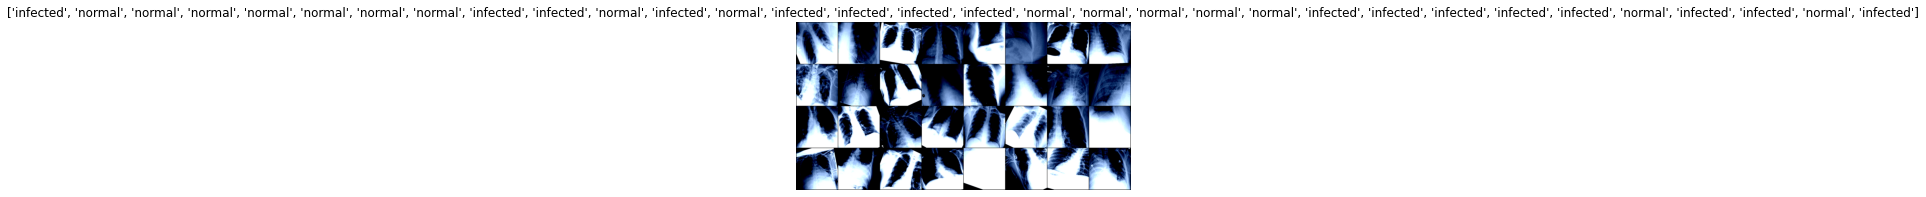

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Task 1: Load pretrained CNN model and fine-tune FC Layers

## 1. VGG16

### Loading pre-trained VGG16

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### Modifying FC layers into 2 new layers

In [8]:
features = list(vgg16.classifier.children())[:4]
features[0].out_features = (30*10)+100
features[-1].in_features = (30*10)+100
features[-1].out_features = len(class_names)
#print(features)
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing convolution layers

In [0]:
# Freeze training for all convolution layers
for param in vgg16.features.parameters():
    param.requires_grad = True

### Loss function and optimizer

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Accuracy function


In [0]:
def Accuracy(model,loader):
    model = model.to(device)
    correct = 0
    total = 0
    lbls = []
    pred = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            lbls.extend(labels.tolist())
            pred.extend(predicted.tolist())
    return correct/total, lbls, pred

### Training

In [13]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
vgg16.to(device)

vgg16.train()
train_loss = []
train_accu = []
validation_loss = []
validation_accu = []

for epoch in range(Epochs):  # loop over the dataset multiple times
    #training
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = vgg16.forward(inputs)     #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    train_loss.append(running_loss)
    train_accu.append(Accuracy(vgg16,trainloader)[0])
    torch.save(vgg16.state_dict(), 'vgg16_FC_entire.pth')
    
    #validation loss
    running_loss = 0.0
    pbar = tqdm(enumerate(validationloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() 
        outputs = vgg16.forward(inputs)     #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(validationloader.dataset),
                100. * i / len(validationloader),
                loss.data))
    validation_loss.append(running_loss) 
    validation_accu.append(Accuracy(vgg16,validationloader)[0])

print('Finished Training')

device: cuda:0


Train Epoch: 0 [9045/10747 (100%)]	Loss: 0.376373: : 336it [21:32,  3.85s/it]
Validation Epoch: 0 [1288/1500 (98%)]	Loss: 0.465716: : 47it [03:28,  4.43s/it]
Train Epoch: 1 [9045/10747 (100%)]	Loss: 0.128098: : 336it [03:52,  1.44it/s]
Validation Epoch: 1 [1288/1500 (98%)]	Loss: 0.312581: : 47it [00:24,  1.94it/s]
Train Epoch: 2 [9045/10747 (100%)]	Loss: 0.452522: : 336it [03:51,  1.45it/s]
Validation Epoch: 2 [1288/1500 (98%)]	Loss: 0.227542: : 47it [00:24,  1.96it/s]
Train Epoch: 3 [9045/10747 (100%)]	Loss: 0.618673: : 336it [03:53,  1.44it/s]
Validation Epoch: 3 [1288/1500 (98%)]	Loss: 0.093453: : 47it [00:24,  1.91it/s]
Train Epoch: 4 [9045/10747 (100%)]	Loss: 0.284859: : 336it [03:52,  1.44it/s]
Validation Epoch: 4 [1288/1500 (98%)]	Loss: 0.308404: : 47it [00:24,  1.92it/s]
Train Epoch: 5 [9045/10747 (100%)]	Loss: 0.306746: : 336it [03:55,  1.43it/s]
Validation Epoch: 5 [1288/1500 (98%)]	Loss: 0.216709: : 47it [00:24,  1.92it/s]
Train Epoch: 6 [9045/10747 (100%)]	Loss: 0.163646: :

Finished Training


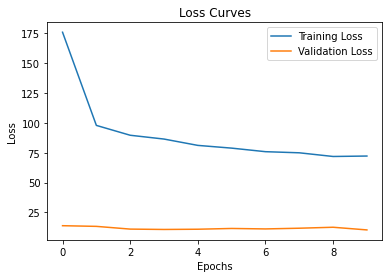

In [14]:
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')
plt.show()

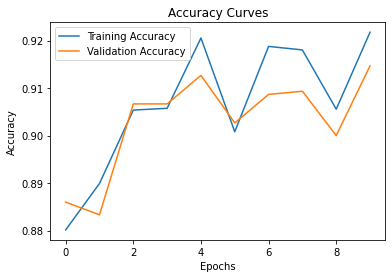

In [15]:
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(train_accu, label='Training Accuracy')
plt.plot(validation_accu, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


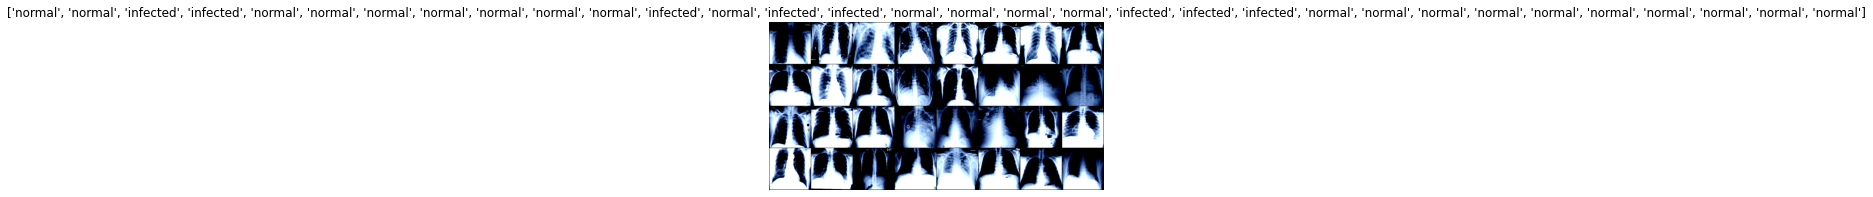

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [17]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected infected normal normal normal normal normal normal normal infected infected infected infected normal normal normal normal infected infected infected normal normal normal normal normal normal infected normal normal normal
Ground Truth:  normal normal infected infected normal normal normal normal normal normal normal infected normal infected infected normal normal normal normal infected infected infected normal normal normal normal normal normal normal normal normal normal


In [18]:
acc, lbls, pred = Accuracy(vgg16,testloader)
print('Accuracy of the network on the 1500 test images: %d %%' % (100 * acc))

Accuracy of the network on the 1500 test images: 97 %


In [20]:
def ConfusionMatrix(lbls,pred):
    from sklearn import metrics
    print(metrics.confusion_matrix(lbls, pred))
    print(metrics.classification_report(lbls, pred, labels=[0,1]))

ConfusionMatrix(lbls,pred)

[[594  21]
 [ 14 871]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       615
           1       0.98      0.98      0.98       885

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [0]:
for i in range(len(lbls)):
    if(lbls[i]==0 and pred[i]==1):
        print("0 as 1", i)
    if(lbls[i]==1 and pred[i]==0):
        print("1 as 0", i)